In [46]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


In [47]:
df_train=pd.read_csv("/Users/marcelo/Desktop/UC Berkeley/MFE 2019/Machine Learning/BlueOwl Data Challenge/train.csv")
df_test=pd.read_csv("/Users/marcelo/Desktop/UC Berkeley/MFE 2019/Machine Learning/BlueOwl Data Challenge/test.csv")

In [48]:
df_train.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0


In [49]:
# Let's look at distribution of outcome class

In [50]:
df_train['outcome'].value_counts()

0    9018
1     982
Name: outcome, dtype: int64

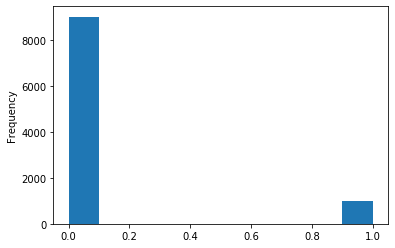

Outcome class is imbalanced


In [51]:
df_train['outcome'].astype(int).plot.hist()
plt.show()
print("Outcome class is imbalanced")

In [52]:
df_train.describe()

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.0000
mean,37.991800,0.004666,0.497500,58004.335800,1.497000,2.00220,5.406800,0.0982
std,13.038203,0.000838,0.500019,17330.778355,0.500016,0.81784,5.046014,0.2976
min,16.000000,0.003171,0.000000,16241.000000,1.000000,1.00000,0.000000,0.0000
25%,27.000000,0.003995,0.000000,45533.500000,1.000000,1.00000,1.000000,0.0000
50%,38.000000,0.004625,0.000000,58053.500000,1.000000,2.00000,4.000000,0.0000
75%,49.000000,0.005164,1.000000,70235.250000,2.000000,3.00000,8.000000,0.0000
max,60.000000,0.007082,1.000000,99956.000000,2.000000,3.00000,22.000000,1.0000


In [53]:
# Let's look at missing data

In [54]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = (df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending = False)
missing_app_train_data  = pd.concat([total, percent],axis=1, keys=['Total', 'Percent'])
missing_app_train_data.head(15)

,Total,Percent
gender,269,2.69
outcome,0,0.00
prior_ins_tenure,0,0.00
n_vehicles,0,0.00
n_drivers,0,0.00
income,0,0.00
in_initial_launch_location,0,0.00
device_type,0,0.00
cost_of_ad,0,0.00
age,0,0.00


In [55]:
df_train["gender"].fillna("no gender", inplace = True)  #fill missing values of gender with "no gender"

In [56]:
#Let's look at correlation matrix to inspect any signs of multicollinearity

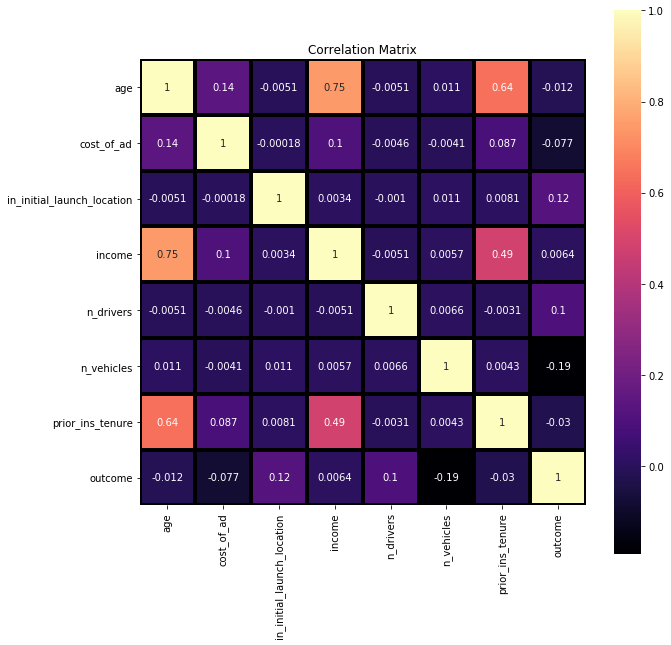

In [57]:
df_correlations=df_train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_correlations, vmax=1, square=True,annot=True,cmap='magma',linewidths=3, linecolor='black')

plt.title('Correlation Matrix')
plt.show()

In [13]:
df_train.dtypes #looking at variable types

age                             int64
cost_of_ad                    float64
device_type                    object
gender                         object
in_initial_launch_location      int64
income                          int64
n_drivers                       int64
n_vehicles                      int64
prior_ins_tenure                int64
outcome                         int64
dtype: object

In [14]:
df_train['device_type'].value_counts() #inspecting number of different categories for object variable

desktop    2032
Android    2023
laptop     1991
other      1986
iPhone     1968
Name: device_type, dtype: int64

In [15]:
df_train['device_type'] = df_train['device_type'].astype('category')
df_train['gender'] = df_train['gender'].astype('category')
df_train = pd.get_dummies(df_train)

In [16]:
#Before modelling, let's look into our test set.

In [17]:
df_test.describe()

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,38.029200,0.004668,0.500900,58232.104800,1.486300,2.009100,5.319800
std,12.896921,0.000836,0.500024,17318.192722,0.499837,0.817242,5.019487
min,16.000000,0.003173,0.000000,16124.000000,1.000000,1.000000,0.000000
25%,27.000000,0.004000,0.000000,45575.250000,1.000000,1.000000,1.000000
50%,38.000000,0.004609,1.000000,58271.000000,1.000000,2.000000,4.000000
75%,49.000000,0.005175,1.000000,70438.750000,2.000000,3.000000,8.000000
max,60.000000,0.007049,1.000000,99916.000000,2.000000,3.000000,22.000000


In [18]:
total = df_test.isnull().sum().sort_values(ascending = False)
percent = (df_test.isnull().sum()/df_test.isnull().count()*100).sort_values(ascending = False)
missing_app_test_data  = pd.concat([total, percent],axis=1, keys=['Total', 'Percent'])
missing_app_test_data.head(15)

,Total,Percent
gender,249,2.49
prior_ins_tenure,0,0.00
n_vehicles,0,0.00
n_drivers,0,0.00
income,0,0.00
in_initial_launch_location,0,0.00
device_type,0,0.00
cost_of_ad,0,0.00
age,0,0.00


In [19]:
df_test["gender"].fillna("no gender", inplace = True)  #fill missing values of gender with "no gender"

In [20]:
df_test['device_type'] = df_test['device_type'].astype('category')
df_test['gender'] = df_test['gender'].astype('category')
df_test = pd.get_dummies(df_test)

In [21]:
X=df_train.drop(['outcome'],axis=1)
y=df_train['outcome'].values.ravel()


X_train, X_validation, y_train, y_validation = train_test_split(X,y,test_size=0.20,random_state=4)

In [22]:
print(X_train.shape)
print(X_validation.shape)
print(X.shape)
print(y.shape)

(8000, 15)
(2000, 15)
(10000, 15)
(10000,)


In [23]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled=scaler.transform(df_test)

X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_validation= pd.DataFrame(X_validation_scaled, columns = X_validation.columns)


In [24]:
y_score_list=[]
classifier_label_list=[]

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,random_state=4)
rf.fit(X_train, y_train)


rf_y_score = rf.predict_proba(X_validation)[:,1]
rf_roc_auc_score = roc_auc_score(y_validation,rf_y_score)
y_score_list.append(rf_y_score)
classifier_label_list.append('Random Forest')
print("Random Forest AUROC score: %.3f" %rf_roc_auc_score)


Random Forest AUROC score: 0.802


In [26]:
kfold = StratifiedKFold(n_splits=10)

In [27]:
clf = LGBMClassifier()
params = {
        'n_estimators' : [100,200,300], 
        'learning_rate': [0.001, 0.01, 0.1], 
        'sub_feature': [0.3],
        'num_leaves': [200],
        'lambda_l2': [0.1], 
        'min_data_in_leaf': [40], 
        'min_samples_leaf': [100,150], 
        'max_depth': [-1,4,8]
}

gLGBM = GridSearchCV(clf, params,cv=kfold,n_jobs=-1, scoring='roc_auc')
gLGBM.fit(X_train,y_train) 
LGBM_best = gLGBM.best_estimator_
gLGBM.best_score_

0.8480495995444336

In [29]:
XGB = XGBClassifier() 
xgb_param = {
    'loss' : ["deviance"], 
    'n_estimators' : [100,200,300],
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [4, 8], 
    'min_samples_leaf': [100,150], 
    'max_features': [0.3, 0.1],
}

gsXGB = GridSearchCV(XGB, param_grid = xgb_param, cv=kfold,n_jobs=-1, scoring="roc_auc")
gsXGB.fit(X_train,y_train)
XGB_best = gsXGB.best_estimator_
gsXGB.best_score_

0.8538750092720203

In [30]:
print("Scale pos_weight parameter for XgBoost: ",df_train['outcome'].value_counts()[0]/df_train['outcome'].value_counts()[1])

Scale pos_weight parameter for XgBoost:  9.183299389002036


## Changing scale_pos_weight to 9 in order to alleviate class imbalance problem

In [31]:
XGB_best=XGBClassifier(max_depth=4,max_features=0.3,min_samples_leaf=100,n_estimators=100,n_jobs=0,scale_pos_weight=9)

In [32]:
kfold = KFold(n_splits=10, random_state=0)
results = cross_val_score(XGB_best, X_train, y_train, cv=kfold,scoring= "roc_auc")
results

array([0.85158621, 0.83709651, 0.83166137, 0.8621    , 0.83733527,
       0.83147961, 0.84756396, 0.88291578, 0.85251736, 0.81104735])

In [33]:
print("Average K-Fold XGBoost AUROC score for training set:",np.mean(results))

Average K-Fold XGBoost AUROC score for training set: 0.8445303431544922


In [34]:
final_model=XGB_best
final_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=4, max_features=0.3, min_child_weight=1,
              min_samples_leaf=100, missing=None, n_estimators=100, n_jobs=0,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=9, seed=None,
              silent=True, subsample=1)

In [35]:
X_train=df_train.drop(['outcome'],axis=1) 
y_train= df_train['outcome']

In [36]:
X_test=df_test

In [37]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled=scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns) 
X_test= pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [38]:
predictions=final_model.predict(X_test)

In [39]:
df_test['outcome']=predictions

In [40]:
df_test['outcome'].value_counts()

0    7532
1    2468
Name: outcome, dtype: int64

## As means of comparison, let's set back pos_scale_weight to 1

In [41]:
XGB_best=XGBClassifier(max_depth=4,max_features=0.3,min_samples_leaf=100,n_estimators=100,n_jobs=0,scale_pos_weight=1)
final_model=XGB_best
final_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=4, max_features=0.3, min_child_weight=1,
              min_samples_leaf=100, missing=None, n_estimators=100, n_jobs=0,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1)

In [42]:
predictions=final_model.predict(X_test)

In [43]:
df_test['outcome']=predictions

In [44]:
df_test['outcome'].value_counts()

0    9710
1     290
Name: outcome, dtype: int64

- We can see that regarding prediction, using a lower pos_scale_weight parameter leads to an underpopulated minority class, whereas for a greater pos_scale_weight parameter the minority class is considerably more populated. 


- There's a trade-off between the two models: the first model(pos_scale_weight=9) will be more prone to incur **False Positives**, while the second model(pos_scale_weight=1) will be more more prone to incur **False Negatives**


- In terms of a loan default analogy, a **False Negative**(predict No default but the loan actually defaults) costs us real money while a **False Positive**(predict default but the loann does not default) is just an opportunity cost. So we should prioritize the model that incurs more false positives -> Model with pos_scale_weight = 9


- The chosen model will have a lower probability cutoff, in terms of what constitutes a default prediction